In [1]:
# Run with python3

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.fftpack as fft
from astropy.io import fits
from scipy import optimize
import poppy
import gpipsfs
from scipy import signal
import os
import pytz
import time
import re

kipac paths

In [ ]:
file1 =  '/Users/MelisaT/Documents/Research/GPIDomeSeeing/data/Reduced/20160229/aored_When_2016.2.29_5.33.19_poldm_phase.fits'
file2 =  '/Users/MelisaT/Documents/Research/GPIDomeSeeing/data/Reduced/20160227/aored_When_2016.2.27_0.2.8_poldm_phase.fits'

laptop paths

In [2]:
file1 =  '/Users/melisatallis/Documents/Research/GPIDomeSeeing/data/aotelem/aored_When_2016.2.27_0.40.14_poldm_phase.fits'
file2 =  '/Users/melisatallis/Documents/Research/GPIDomeSeeing/data/aotelem/aored_When_2016.2.29_22.52.44_poldm_phase.fits'

# Analysis Functions

1. import fits - takes filepath as input and outputs an image cube
2. remove zernikes - takes image cube and outputs image cube with aperture included
3. convert to modal basis - inputs phase cube and outputs DFT of phase cube. Multiplied by a smoothing function to remove hard edge effects.
4. 

I would use the process phase function, which does all of these in a single combined function. 

In [ ]:
def import_fits(filepath):
    '''Takes filepath as input and outputs an image cube.
    '''
    hdulist = fits.open(filepath,memmap=True)
    phase = hdulist[0].data.astype('float')

    return phase

In [ ]:
def remove_zernikes(phase):
    
    m1 = gpipsfs.GeminiPrimary().sample(npix=48)
    avg_phase = np.mean(phase*m1,axis=0)
    
    z_basis = poppy.zernike.zernike_basis_faster(nterms= 6, npix = 48)
    z_coeff = poppy.zernike.opd_expand_nonorthonormal(avg_phase, aperture=m1, nterms=6)
    thin_lens = np.sum(z_coeff[:,None,None]*z_basis[:,:,:],axis=0)
    c_phase = (phase - thin_lens[None,:,:])*m1
    c_phase[np.isnan(c_phase)]=0.

    return c_phase

In [3]:
def process_phase(filepath):

    hdulist = fits.open(filepath,memmap=True)
    phase = hdulist[0].data.astype('float')
    avg_phase = np.nanmean(phase*ap_nan,axis=0)  # used to find average zernikes 

    # remove zernikes form cube
    z_basis = poppy.zernike.zernike_basis_faster(nterms= 6, npix = 48)
    z_coeff = poppy.zernike.opd_expand_nonorthonormal(avg_phase, aperture=ap, nterms=6)
    thin_lens = np.sum(z_coeff[:,None,None]*z_basis[:,:,:],axis=0)

    c_phase = (phase - thin_lens[None,:,:])*ap_nan
    c_phase[np.isnan(c_phase)]=0.
    
    return c_phase

In [24]:
def convert_to_modal_basis(phase, ap):
    
    timesteps, phx, phy = phase.shape 
    phFT = np.zeros((timesteps,phx,phy), dtype=complex)
    norm = 1.0/np.sqrt(ap.sum())
    for t in np.arange(timesteps):
        phFT[t,:,:] = np.fft.fftshift(fft.fft2(phase[t,:,:]*ap))*norm
    print('Done with FT')

    return phFT

In [5]:
def sp_power_spec(phFT):    
    
    timesteps, phx, phy = phase.shape 
    # compute 2d psd cube
    psd2D = np.zeros((timesteps, phx, phy),dtype=float)
    for k in np.arange(phx):
        for l in np.arange(phy):
            psd2D[:,k,l] = np.square(np.abs(phFT[:,k,l]))
    
    avg_psd2D = np.sum(psd2D, axis=0)
    print('Done with PSD')    
    
    # compute radial average of 2d psd cube and frequency
    avg_psd1D =  radialProfile(avg_psd2D)
    
    return avg_psd1D

In [4]:
def radialProfile(image, center=None):
    """
    Calculate the avearge radial profile.

    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    
    """
    ## Calculate the indices from the image
    y,x = np.indices((image.shape)) # first determine radii of all pixels
    
    if not center:
        center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0])
     
    r = np.hypot(x - center[0], y - center[1]).astype(np.int) 
    n = np.bincount(r.ravel())
    sy = np.bincount(r.ravel(), image.ravel())
    mean = sy/n
    
    return mean

In [ ]:
def sri_power_spec_wo_folding(mode):
    
    total_len = len(mode)
    per_len = interval_length
    
    # Define indices
    num_intervals = np.floor(total_len/per_len).astype(int)
    start_indices = np.arange(num_intervals,dtype=int)
    ind = np.arange(per_len, dtype=float)
    
    # blackman window
    window = 0.42 - 0.50 * np.cos(2 * np.pi * ind/(per_len-1)) + 0.08 * np.cos(4 * np.pi * ind/(per_len-1)) 
    
    # psd calculation
    psd = np.zeros(len(mode))
    for a in np.arange(num_intervals):
        this_start = start_indices[a]
        psd = psd + np.abs((fft.fft(mode[this_start:(this_start+per_len)]*window)))**2
        
    win2 = window**2
    psd = psd/(num_intervals*per_len*win2.sum())
    
    return psd

In [ ]:
def sri_power_spec(mode, interval_length = 1024):
    
    total_len = len(mode)
    per_len = interval_length
    
    # Define indices
    num_intervals = np.floor(total_len/per_len).astype(int)
    start_indices = np.arange(num_intervals,dtype=int)
    ind = np.arange(per_len, dtype=float)
    
    # blackman window
    window = 0.42 - 0.50 * np.cos(2 * np.pi * ind/(per_len-1)) + 0.08 * np.cos(4 * np.pi * ind/(per_len-1)) 
    
    # psd calculation
    psd = np.zeros(per_len)
    for a in np.arange(num_intervals):
        this_start = start_indices[a]
        psd = psd + np.abs((fft.fft(mode[this_start:(this_start+per_len)]*window)))**2
        
    win2 = window**2
    psd = psd/(num_intervals*per_len*win2.sum())
    
    return psd

In [45]:
def temp_power_spec(Y):
    
    n = len(Y)
    P = np.fft.fft(Y)
    norm = 1.0/n
    P = P * norm
    P2 = np.square(np.abs(P))
    
    return P2

In [19]:
def linear_fit(k,Y,low_b,up_b):

    par = np.polyfit(np.log10(k[(k>low_b) & (k<up_b)]), np.log10(Y[(k>low_b) & (k<up_b)]), 1)
    slope = par[0]
    intercept = par[1]
    print(slope,intercept)
    return slope, intercept   

In [40]:
def power_law(k,amp,exp):
    return 10**amp*k**exp

# Test to find PSD of modes

Convert to fourier modes

In [10]:
# GPI physical parameters
n = 48
pscale = 0.18
M1 = gpipsfs.GeminiPrimary().sample(npix =n)
apod = gpipsfs.GPI_Apodizer().sample(npix=n)

# make spatial frequncy grid
kx = fft.fftshift(fft.fftfreq(n,pscale))
ky = fft.fftshift(fft.fftfreq(n,pscale))
mg = np.meshgrid(kx,ky)
kr = np.sqrt(np.sum((m**2 for m in mg)))
k = radialProfile(kr)

# Import fits 
#phase = import_fits(file2)
#c_phase = remove_zernikes(phase)

Home-made aperture

In [11]:
#  Aperture containing zeros
x = np.linspace(-(n)/2,(n)/2,n)*pscale 
y = np.linspace(-(n)/2,(n)/2,n)*pscale
mg = np.meshgrid(x,y)
ar = np.sqrt(np.sum((m**2 for m in mg)))
ap_outer = (ar <= (7.3)/2) #mask is slightly oversized because GPI does not correct the boundaries well
ap_inner = (ar <= 1.5/2)   

#ap_outer = (ar <= outD/2)
#ap_inner = (ar <= inD/2)   
ap = (ap_outer ^ ap_inner).astype(np.float)

#  Aperture containing nans
ap_nan = np.copy(ap.astype(np.float))  
ap_nan[np.where(ap==0)] = np.nan

In [ ]:
phFT_1 = convert_to_modal_basis(c_phase,ap = ap)
sp_psd_1 = sp_power_spec(phFT_1)

In [ ]:
phFT_2 = convert_to_modal_basis(c_phase,ap = M1)
sp_psd_2 = sp_power_spec(phFT_2)

In [ ]:
phFT_3 = convert_to_modal_basis(c_phase,ap = apod)
sp_psd_3 = sp_power_spec(phFT_3)

In [ ]:
%matplotlib notebook

plt.loglog(k,sp_psd_1)
plt.loglog(k,sp_psd_2)
plt.loglog(k,sp_psd_3)


slope_1, yint_1 = linear_fit(k,sp_psd_1,.33,1)
slope_2, yint_2 = linear_fit(k,sp_psd_2,.33,1)
slope_3, yint_3 = linear_fit(k,sp_psd_3,.33,1)

#bounds = (k>.33)&(k<1)
#plt.plot(k[bounds],10**yint*k[bounds]**slope)

# Test to find PSD of temporal modes

In [61]:
%matplotlib notebook

from scipy.signal import welch
mode = yFT_2D[:,10,10]
f, psd = welch(mode,
               fs=.001,  # sample rate
               window='blackman',   # apply a Hanning window before taking the DFT
               nperseg=1024,        # compute periodograms of 256-long segments of x
               detrend='constant') # detrend x by subtracting the mean
keep = f>0.0
f_keep = f[keep]
plt.loglog(f[keep],psd[keep])

slope, yint = linear_fit(f[keep],psd[keep],10,100)
x = f_keep[(f_keep>10) & (f_keep<100)]
y = power_law(amp = yint,exp=slope,k=x)
plt.loglog(x,y)

/anaconda3/lib/python3.6/site-packages/scipy/signal/spectral.py:1623: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


<IPython.core.display.Javascript object>

TypeError: expected non-empty vector for x

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


Done with FT
-3.2702700948493275 -1.049261248648438


<IPython.core.display.Javascript object>


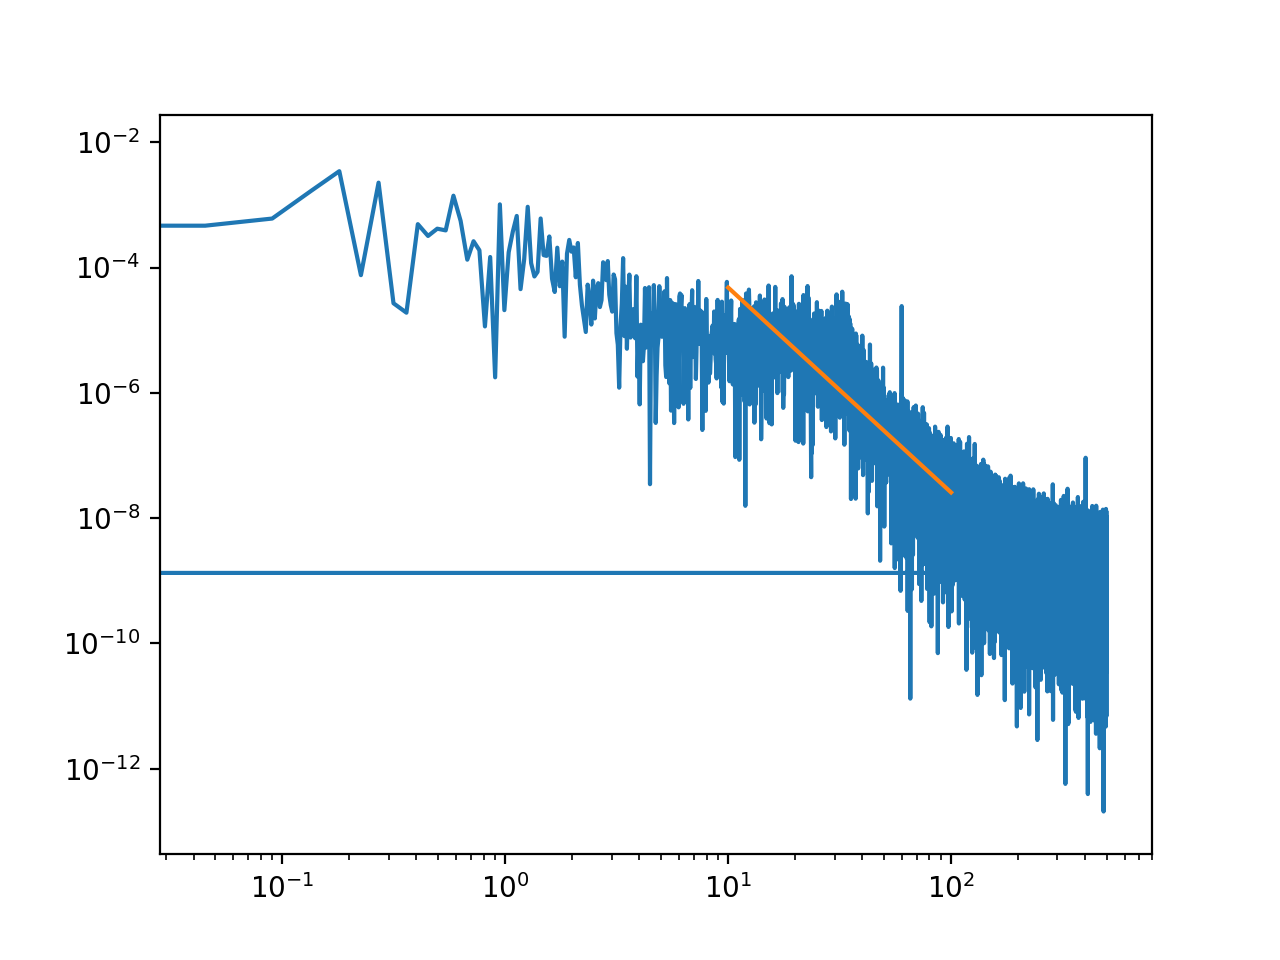

In [51]:
%matplotlib notebook

y_2D = process_phase(file1)
#y_1D = np.mean(y_2D,axis=(1,2))
yFT_2D = convert_to_modal_basis(y_2D,ap)
mode = yFT_2D[:,4,4]
kt = fft.fftfreq(len(mode),.001)
t_psd = temp_power_spec(mode)
slope, yint = linear_fit(kt,t_psd,10,100)

# psd of individual mode
plt.loglog(kt,t_psd)

# show fit
x = kt[(kt>10) & (kt<100)]
y = power_law(amp = yint,exp=slope,k=x)
plt.loglog(x,y)

In [31]:
np.shape(y_2D)

(22190, 48, 48)

In [ ]:
%matplotlib notebook

y_1D = np.mean(c_phase,axis=(1,2))
kt = fft.rfftfreq(1024,.001)
t_psd = sri_power_spec(y_1D)
smooth = 10**signal.savgol_filter(np.log10(t_psd), 101, 5)
slope, yint = linear_fit(kt,t_psd,1,40)
slope, yint = linear_fit(kt,smooth,1,40)

plt.loglog(kt,t_psd)
plt.loglog(kt,smooth)

In [ ]:
%matplotlib notebook

#k = fft.rfftfreq(1024,.001)
y_1D = np.mean(c_phase,axis=(1,2))
kt = fft.rfftfreq(len(c_phase[:,15,15]),.001)
t_psd = temp_power_spec(y_1D)
#smooth = 10**signal.savgol_filter(np.log10(t_psd), 101, 5)
slope, yint = linear_fit(kt,t_psd,1,40)
#slope, yint = linear_fit(kt,smooth,1,40)

plt.loglog(kt,t_psd)
plt.loglog(kt,smooth)